In [1]:
%load_ext autoreload
%autoreload 2

import sys 
from os import getcwd, path
sys.path.append(path.dirname(getcwd()))
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
from utils import data

In [3]:
cohort = data.init_cohort(join_with="tcr_tumor",
                          exclude_patient_ids=set(),
                          only_patients_with_bams=False)

inner join with tcr_tumor: 29 to 24 rows
inner join with tcr_tumor: 29 to 24 rows
{'dataframe_hash': -2467646966976180658,
 'provenance_file_summary': {u'cohorts': u'0.4.0+3.gda968fb',
                             u'isovar': u'0.0.6',
                             u'mhctools': u'0.3.0',
                             u'numpy': u'1.11.1',
                             u'pandas': u'0.18.1',
                             u'pyensembl': u'1.0.3',
                             u'scipy': u'0.18.1',
                             u'topiary': u'0.1.0',
                             u'varcode': u'0.5.10'}}


In [4]:
def clonality(row):
    return row["Clonality"]

In [5]:
def tcell_fraction(row):
    return row["T-cell fraction"]

In [6]:
from utils.paper import *

In [7]:
df = cohort.as_dataframe([clonality, tcell_fraction])

inner join with tcr_tumor: 29 to 24 rows


{{{til_fraction_vs_clonality_benefit}}}
inner join with tcr_tumor: 29 to 24 rows


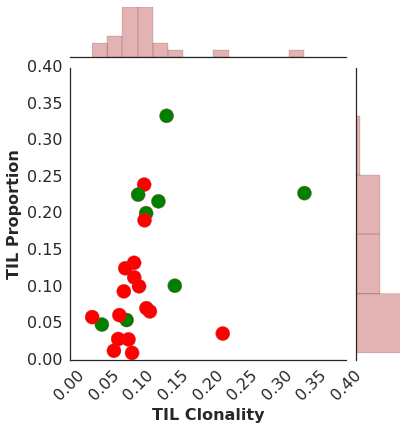

In [8]:
hyper_figure_label_printer(label="til_fraction_vs_clonality_benefit")
results = cohort.plot_correlation(on={"TIL Clonality": clonality, "TIL Proportion": tcell_fraction}, x_col="TIL Clonality", 
                          show_stat_func=False,
                          plot_kwargs={"s": 200,
                                            "xlim": (0, 0.4),
                                            "ylim": (0, 0.4),
                                            "c": ["green" if benefit else "red" for benefit in df.is_benefit]})
results.plot.ax_joint.set_xticklabels(
        results.plot.ax_joint.xaxis.get_majorticklabels(), rotation=45)

In [9]:
def add_rescaled_cols(d, col):
    import numpy as np
    log_col = "log_%s" % col
    log_col_centered = "log_%s_centered" % col
    log_col_rescaled = "log_%s_rescaled" % col
    d[log_col] = np.log1p(d[col])
    d[log_col_centered] = d[log_col] - np.mean(d[log_col])
    d[log_col_rescaled] = d[log_col_centered] / np.std(d[log_col_centered])

In [10]:
add_rescaled_cols(df, "tcell_fraction")
add_rescaled_cols(df, "clonality")

inner join with tcr_tumor: 29 to 24 rows
Mann-Whitney test: U=97.0, p-value=0.0465677613869 (two-sided)
{{{til_fraction_benefit_plot}}}
{{{til_fraction_benefit_benefit:0.21 (range 0.049-0.33)}}}
{{{til_fraction_benefit_no_benefit:0.069 (range 0.0098-0.24)}}}
{{{til_fraction_benefit_mw:n=24, Mann-Whitney p=0.047}}}


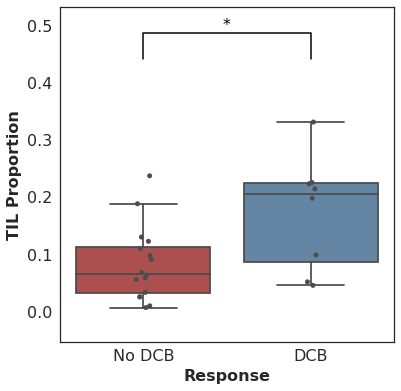

In [11]:
mann_whitney_hyper_label_printer(cohort.plot_benefit(on={"TIL Proportion": tcell_fraction}), label="til_fraction_benefit")

inner join with tcr_tumor: 29 to 24 rows
Mann-Whitney test: U=91.0, p-value=0.104634955402 (two-sided)
{{{til_clonality_benefit_plot}}}
{{{til_clonality_benefit_benefit:0.12 (range 0.047-0.34)}}}
{{{til_clonality_benefit_no_benefit:0.092 (range 0.033-0.22)}}}
{{{til_clonality_benefit_mw:n=24, Mann-Whitney p=0.10}}}


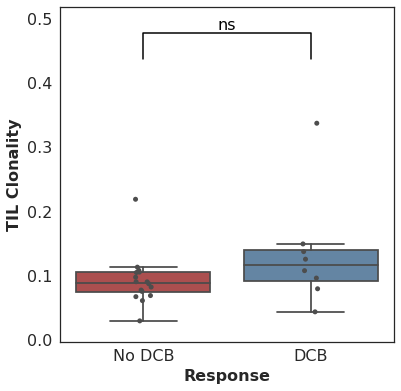

In [12]:
mann_whitney_hyper_label_printer(cohort.plot_benefit(on={"TIL Clonality": clonality}), label="til_clonality_benefit")

In [13]:
def clonality_proportion_dcb_plot(ax=None):
    if ax is None:
        ax = plt.gca()
        
    ax = plt.gca()
    results_clonality = cohort.plot_benefit(on="Clonality", ax=ax)
    clonality_significant = results_clonality.p_value <= 0.05
    results_fraction = cohort.plot_benefit(on="T-cell fraction", ax=ax)
    fraction_signficiant = results_fraction.p_value <= 0.05
    ax.clear()
    
    cols, df_clonality_fraction_init = cohort.as_dataframe(on={"TIL Clonality": "Clonality", 
                                                               "TIL Proportion": "T-cell fraction"},
                                                      return_cols=True)
    df_clonality_fraction_benefit = df_clonality_fraction_init[["patient_id", "benefit"]].set_index("patient_id")
    df_clonality_fraction = df_clonality_fraction_init[cols + ["patient_id"]]
    df_clonality_fraction.set_index("patient_id", inplace=True)
    df_clonality_fraction = pd.DataFrame(df_clonality_fraction.unstack())
    df_clonality_fraction["TIL Measurement"] = df_clonality_fraction.index.get_level_values(0)
    df_clonality_fraction.columns = ["Percent", "TIL Measurement"]
    df_clonality_fraction = df_clonality_fraction.join(df_clonality_fraction_benefit)
    df_clonality_fraction["Response"] = df_clonality_fraction.benefit.apply(
        lambda b: cohort.benefit_plot_name if b else "No " + cohort.benefit_plot_name)

    def add_significance_indicators(plot, indicators=[]):
        from cohorts.plot import vertical_percent
        plot_bottom, plot_top = plot.get_ylim()
        # Give the plot a little room for the significance indicator
        line_height = vertical_percent(plot, 0.1)
        # Add some extra spacing below the indicator
        plot_top = plot_top + line_height
        # Add some extra spacing above the indicator
        plot.set_ylim(top=plot_top + line_height * 2)
        color = "black"
        line_top = plot_top + line_height
        for col_a, col_b, significant in indicators:
            plot.plot([col_a, col_a, col_b, col_b], [plot_top, line_top, line_top, plot_top], lw=1.5, color=color)
            indicator = "*" if significant else "ns"
            plot.text((col_a + col_b) * 0.5, line_top, indicator, ha="center", va="bottom", color=color)
    
    box_ax = sb.boxplot(data=df_clonality_fraction, y="Percent", x="TIL Measurement", hue="Response",
                         ax=ax)
    # http://stackoverflow.com/questions/35538882/seaborn-boxplot-stripplot-duplicate-legend
    strip_ax = sb.stripplot(data=df_clonality_fraction, jitter=0.05, palette={cohort.benefit_plot_name: "0.3", 
                                                                              ("No " + cohort.benefit_plot_name): "0.3"}, split=True, y="Percent", x="TIL Measurement", hue="Response",
                         ax=ax)
    
    add_significance_indicators(ax, [(-0.2, 0.2, clonality_significant), (0.8, 1.2, fraction_signficiant)])
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend_.remove()
    l = ax.legend(handles[0:2], labels[0:2], bbox_to_anchor=(0, 0.7), loc=2, borderaxespad=0.)

{{{clonality_proportion_benefit_plot}}}
inner join with tcr_tumor: 29 to 24 rows
Mann-Whitney test: U=91.0, p-value=0.104634955402 (two-sided)
inner join with tcr_tumor: 29 to 24 rows
Mann-Whitney test: U=97.0, p-value=0.0465677613869 (two-sided)
inner join with tcr_tumor: 29 to 24 rows


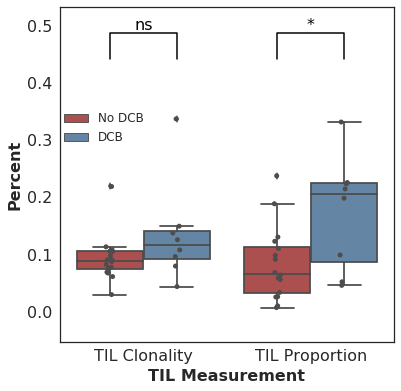

In [14]:
hyper_figure_label_printer("clonality_proportion_benefit_plot")
clonality_proportion_dcb_plot()

inner join with tcr_tumor: 29 to 24 rows
# no condition 12
# with condition 12
{{{til_clonality_curves_os_plot}}}
{{{til_clonality_curves_os_logrank:n=24, log-rank p=0.47}}}


/home/tavi/miniconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:224: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return reshape(newshape, order=order)


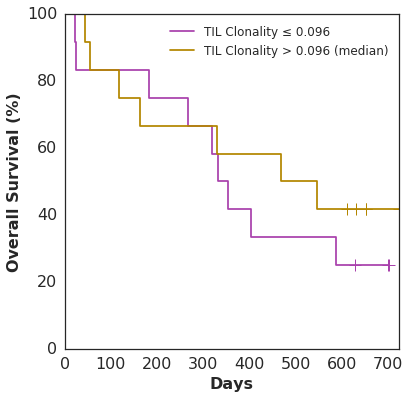

In [15]:
survival_hyper_label_printer(
cohort.plot_survival(on={"TIL Clonality": clonality}, how="os"),
    label="til_clonality_curves_os")

inner join with tcr_tumor: 29 to 24 rows
# no condition 12
# with condition 12
{{{til_clonality_curves_pfs_plot}}}
{{{til_clonality_curves_pfs_logrank:n=24, log-rank p=0.51}}}


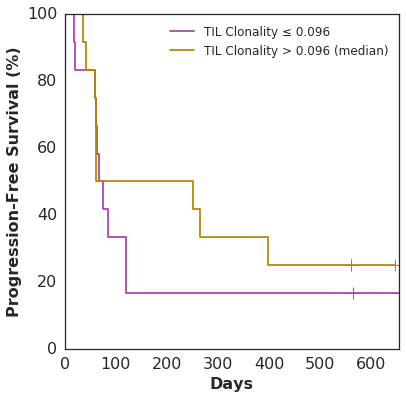

In [16]:
survival_hyper_label_printer(
cohort.plot_survival(on={"TIL Clonality": clonality}, how="pfs"),
    label="til_clonality_curves_pfs")

inner join with tcr_tumor: 29 to 24 rows
# no condition 12
# with condition 12
{{{til_proportion_curves_os_plot}}}
{{{til_proportion_curves_os_logrank:n=24, log-rank p=0.26}}}


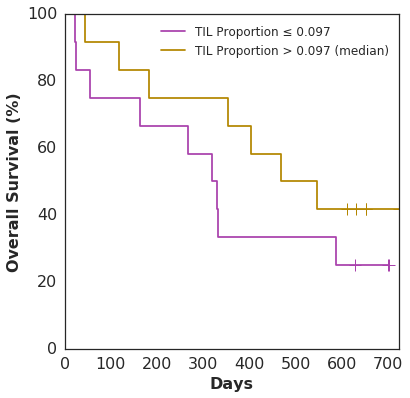

In [17]:
survival_hyper_label_printer(
cohort.plot_survival(on={"TIL Proportion": tcell_fraction}, how="os"),
    label="til_proportion_curves_os")

inner join with tcr_tumor: 29 to 24 rows
# no condition 12
# with condition 12
{{{til_proportion_curves_pfs_plot}}}
{{{til_proportion_curves_pfs_logrank:n=24, log-rank p=0.32}}}


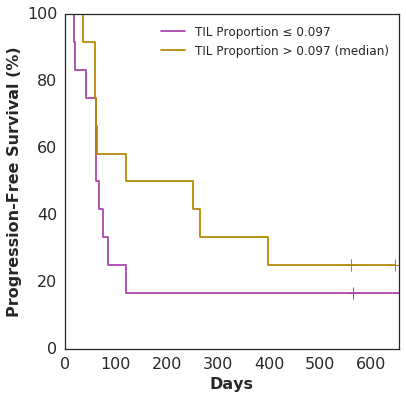

In [18]:
survival_hyper_label_printer(
cohort.plot_survival(on={"TIL Proportion": tcell_fraction}, how="pfs"),
    label="til_proportion_curves_pfs")

In [19]:
def below_tcf_median(row):
    return row["T-cell fraction"] < df["T-cell fraction"].median()

In [20]:
def below_clonality_median(row):
    return row["Clonality"] < df["Clonality"].median()

In [21]:
def clonality_median(row):
    return df["Clonality"].median()

In [22]:
def tcell_fraction_median(row):
    return df["T-cell fraction"].median()

In [23]:
def below_either_median(row):
    either = ((row["Clonality"] < df["Clonality"].median()) or 
              (row["T-cell fraction"] < df["T-cell fraction"].median()))
    return either

In [24]:
df_below_medians = cohort.as_dataframe(on=[clonality_median, tcell_fraction_median])[["patient_id", "benefit", "Clonality", "clonality_median", "T-cell fraction", "tcell_fraction_median"]]

inner join with tcr_tumor: 29 to 24 rows


In [25]:
df_below_medians["below_tcf"] = df_below_medians.apply(lambda row: row["T-cell fraction"] < row["tcell_fraction_median"], axis=1)
df_below_medians["below_clonality"] = df_below_medians.apply(lambda row: row["Clonality"] < row["clonality_median"], axis=1)

In [26]:
df_below_medians 

,patient_id,benefit,Clonality,clonality_median,T-cell fraction,tcell_fraction_median,below_tcf,below_clonality
0,0040,False,0.063967,0.096131,0.0128,0.09745,True,True
1,0471,False,0.115946,0.096131,0.0666,0.09745,True,False
2,1233,True,0.128326,0.096131,0.2171,0.09745,False,False
3,1249,False,0.221381,0.096131,0.0363,0.09745,True,False
4,1849,True,0.339484,0.096131,0.2283,0.09745,False,False
5,1994,False,0.093285,0.096131,0.1131,0.09745,False,True
6,2131,True,0.110512,0.096131,0.2009,0.09745,False,False
7,2278,True,0.046536,0.096131,0.0486,0.09745,True,True
8,2389,True,0.140133,0.096131,0.3340,0.09745,False,False
9,2849,False,0.085056,0.096131,0.0283,0.09745,True,True


In [27]:
df_below_medians[~df_below_medians.benefit]

,patient_id,benefit,Clonality,clonality_median,T-cell fraction,tcell_fraction_median,below_tcf,below_clonality
0,0040,False,0.063967,0.096131,0.0128,0.09745,True,True
1,0471,False,0.115946,0.096131,0.0666,0.09745,True,False
3,1249,False,0.221381,0.096131,0.0363,0.09745,True,False
5,1994,False,0.093285,0.096131,0.1131,0.09745,False,True
9,2849,False,0.085056,0.096131,0.0283,0.09745,True,True
10,2937,False,0.107643,0.096131,0.2400,0.09745,False,False
11,3529,False,0.093133,0.096131,0.1330,0.09745,False,True
12,4072,False,0.032501,0.096131,0.0588,0.09745,True,True
15,5338,False,0.071801,0.096131,0.0615,0.09745,True,True
17,6428,False,0.110947,0.096131,0.0710,0.09745,True,False


In [28]:
df_below_medians[df_below_medians.benefit].below_tcf.sum()

2

In [29]:
df_below_medians[df_below_medians.benefit].below_clonality.sum()

2

In [30]:
df_below_medians[~df_below_medians.benefit].below_tcf.sum()

10

In [31]:
df_below_medians[~df_below_medians.benefit].below_clonality.sum()

10

In [32]:
df_below_medians[df_below_medians.benefit].below_tcf.apply(lambda x: 1 if x == 0 else 0).sum()

6

In [33]:
df_below_medians[df_below_medians.benefit].below_tcf

2     False
4     False
6     False
7      True
8     False
13    False
14     True
16    False
Name: below_tcf, dtype: bool

In [34]:
df_below_medians[df_below_medians.benefit].below_clonality

2     False
4     False
6     False
7      True
8     False
13    False
14     True
16    False
Name: below_clonality, dtype: bool

In [35]:
df_below_medians[df_below_medians.benefit].below_clonality.apply(lambda x: 1 if x == 0 else 0).sum()

6

In [36]:
df_below_medians[~df_below_medians.benefit].below_tcf

0      True
1      True
3      True
5     False
9      True
10    False
11    False
12     True
15     True
17     True
18    False
19    False
20    False
21     True
22     True
23     True
Name: below_tcf, dtype: bool

In [37]:
df_below_medians[~df_below_medians.benefit].below_clonality

0      True
1     False
3     False
5      True
9      True
10    False
11     True
12     True
15     True
17    False
18    False
19     True
20    False
21     True
22     True
23     True
Name: below_clonality, dtype: bool

inner join with tcr_tumor: 29 to 24 rows
< Median TIL Proportion  False  True 
Response                             
DCB                          6      2
No DCB                       6     10
Fisher's Exact Test: OR: 5.0, p-value=0.193027325347 (two-sided)
{{{below_median_til_fraction_dcb_plot}}}
{{{below_median_til_fraction_dcb_benefit:25%}}}
{{{below_median_til_fraction_dcb_no_benefit:63%}}}
{{{below_median_til_fraction_dcb_fishers:n=24, Fisher's Exact p=0.19}}}


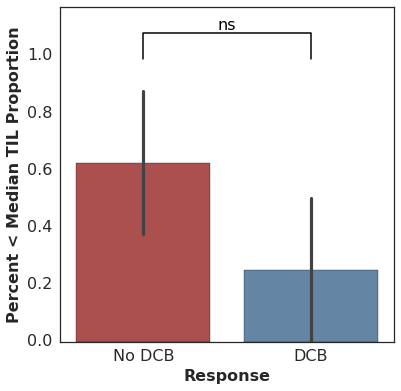

In [38]:
fishers_exact_hyper_label_printer(cohort.plot_benefit({"< Median TIL Proportion": below_tcf_median}),
                                 label="below_median_til_fraction_dcb")

inner join with tcr_tumor: 29 to 24 rows
< Median TIL Clonality  False  True 
Response                            
DCB                         6      2
No DCB                      6     10
Fisher's Exact Test: OR: 5.0, p-value=0.193027325347 (two-sided)
{{{below_median_til_clonality_dcb_plot}}}
{{{below_median_til_clonality_dcb_benefit:25%}}}
{{{below_median_til_clonality_dcb_no_benefit:63%}}}
{{{below_median_til_clonality_dcb_fishers:n=24, Fisher's Exact p=0.19}}}


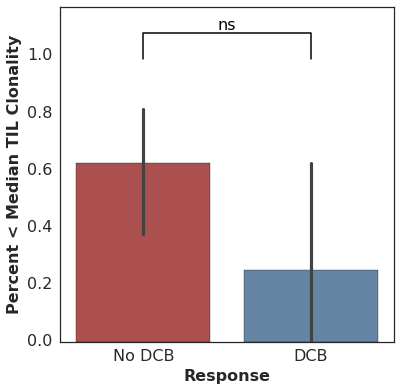

In [39]:
fishers_exact_hyper_label_printer(cohort.plot_benefit({"< Median TIL Clonality": below_clonality_median}),
                                  label="below_median_til_clonality_dcb")

{{{below_median_til_clonality_fraction_two_panel_dcb_plot}}}
inner join with tcr_tumor: 29 to 24 rows
< Median TIL Clonality  False  True 
Response                            
DCB                         6      2
No DCB                      6     10
Fisher's Exact Test: OR: 5.0, p-value=0.193027325347 (two-sided)
inner join with tcr_tumor: 29 to 24 rows
< Median TIL Proportion  False  True 
Response                             
DCB                          6      2
No DCB                       6     10
Fisher's Exact Test: OR: 5.0, p-value=0.193027325347 (two-sided)


FishersExactResults(oddsratio=5.0, p_value=0.193027325347, sided_str='two-sided')

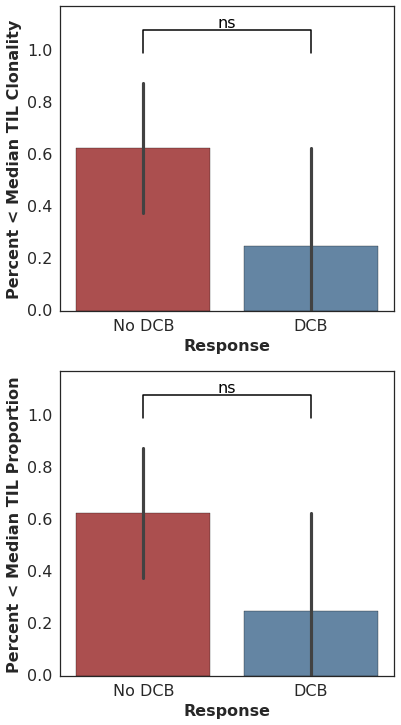

In [40]:
fig, axarr = plt.subplots(2, 1)
fig.set_size_inches(2500 / 400, 5000 / 400)
hyper_figure_label_printer("below_median_til_clonality_fraction_two_panel_dcb_plot")
cohort.plot_benefit({"< Median TIL Clonality": below_clonality_median}, ax=axarr[0])
cohort.plot_benefit({"< Median TIL Proportion": below_tcf_median}, ax=axarr[1])

inner join with tcr_tumor: 29 to 24 rows
< Median TIL Proportion or Clonality  False  True 
Response                                          
DCB                                       6      2
No DCB                                    3     13
Fisher's Exact Test: OR: 13.0, p-value=0.0214882707816 (two-sided)
{{{below_median_til_fraction_clonality_dcb_plot}}}
{{{below_median_til_fraction_clonality_dcb_benefit:25%}}}
{{{below_median_til_fraction_clonality_dcb_no_benefit:81%}}}
{{{below_median_til_fraction_clonality_dcb_fishers:n=24, Fisher's Exact p=0.021}}}


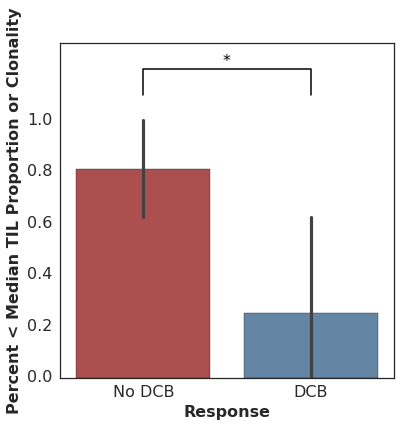

In [41]:
fishers_exact_hyper_label_printer(cohort.plot_benefit({"< Median TIL Proportion or Clonality": below_either_median}),
                                  label="below_median_til_fraction_clonality_dcb")

In [42]:
def crpr(row):
    best_response = row["Best Response RECIST 1.1"].strip().lower()
    if best_response in ["cr", "pr"]:
        return True
    if best_response in ["pd"] or "baseline" in best_response:
        return False
    return np.nan

inner join with tcr_tumor: 29 to 24 rows
Missing crpr for 4 patients: from 24 to 20
Mann-Whitney test: U=70.0, p-value=0.0571934817481 (two-sided)


MannWhitneyResults(U=70.0, p_value=0.0571934817481, sided_str='two-sided')

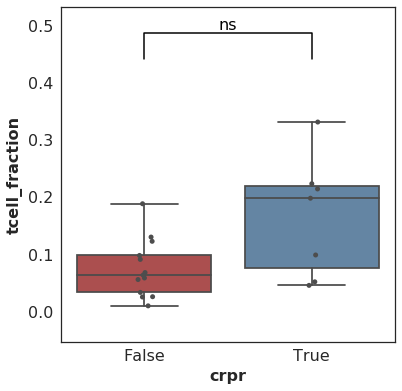

In [43]:
cohort.plot_boolean(on=[tcell_fraction, crpr], plot_col="tcell_fraction", boolean_col="crpr")

In [44]:
# Adapted from statsmodels.sourceforge.net/devel/generated/statsmodels.regression.linear_model.OLSResults.html compare_lr
def compare_lr(model, other_model):
    from scipy import stats
    ll_model = model.llf
    ll_other_model = other_model.llf
    df_model = model.df_resid
    df_other_model = other_model.df_resid

    lrdf = (df_other_model - df_model)
    lrstat = -2*(ll_other_model - ll_model)
    lr_pvalue = stats.chi2.sf(lrstat, lrdf)
    return lrstat, lr_pvalue, lrdf

In [45]:
import statsmodels.api as sm
from statsmodels.formula.api import logit, probit, poisson, ols

In [46]:
df["benefit"] = df["benefit"].apply(lambda b: 1 if b else 0)

In [47]:
null_model = logit("benefit ~ 1", df).fit()
model_tcf = logit("benefit ~ log_tcell_fraction_rescaled", df).fit()
model_clonality = logit("benefit ~ log_clonality_rescaled", df).fit()
model_tcf_clonality = logit("benefit ~ log_clonality_rescaled * log_tcell_fraction_rescaled", df).fit()

Optimization terminated successfully.
         Current function value: 0.636514
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.507964
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.582929
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.412002
         Iterations 9


In [48]:
from utils.paper import float_str

In [49]:
def llr_formatter(results):
    return "n=%d, log-likelihood p=%s" % (len(cohort.as_dataframe()), float_str(results[1]))

In [50]:
hyper_label_printer(llr_formatter, label="llr_tcf_null", results=(compare_lr(model_tcf, null_model)))

inner join with tcr_tumor: 29 to 24 rows
{{{llr_tcf_null:n=24, log-likelihood p=0.013}}}


In [51]:
hyper_label_printer(llr_formatter, label="llr_clonality_null", results=(compare_lr(model_tcf, null_model)))

inner join with tcr_tumor: 29 to 24 rows
{{{llr_clonality_null:n=24, log-likelihood p=0.013}}}


In [52]:
hyper_label_printer(llr_formatter, label="llr_tcf_clonality_tcf", results=(compare_lr(model_tcf_clonality, model_tcf)))

inner join with tcr_tumor: 29 to 24 rows
{{{llr_tcf_clonality_tcf:n=24, log-likelihood p=0.100}}}


In [53]:
hyper_label_printer(llr_formatter, label="llr_tcf_clonality_clonality", results=(compare_lr(model_tcf_clonality, model_clonality)))

inner join with tcr_tumor: 29 to 24 rows
{{{llr_tcf_clonality_clonality:n=24, log-likelihood p=0.017}}}
